In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torch
from torch.utils.data import DataLoader

def scan_dataset(root_dir):
    
    image_paths = []
    labels = []
    
    for class_name in sorted(os.listdir(root_dir)):
        class_folder = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_folder):
            continue
        for fname in sorted(os.listdir(class_folder)):
            if fname.lower().endswith(('.jpg')):
                image_paths.append(os.path.join(class_folder, fname))
                labels.append(class_name)
    
    return image_paths, labels

class LandmarkDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None):           # Stores image paths, labels, and transforms.
        self.image_paths = image_paths
        self.labels = labels                                                # None for test set
        self.transform = transform
        
    def __len__(self):                                                      # returns the number of images in the dataset.
        return len(self.image_paths)

    def __getitem__(self, idx):                                             # loads and returns an image and its label (if available).
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return img, label
        else:
            return img, img_path                                             # return path for query images

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

train_paths, train_labels = scan_dataset("data/train")
val_paths, val_labels = scan_dataset("data/val")
test_paths, _ = scan_dataset("data/test")

classes = sorted(set(train_labels))
class_to_idx = {c:i for i,c in enumerate(classes)}
train_labels_idx = [class_to_idx[c] for c in train_labels]
val_labels_idx = [class_to_idx[c] for c in val_labels]

train_dataset = LandmarkDataset(train_paths, train_labels_idx, train_transform)
val_dataset = LandmarkDataset(val_paths, val_labels_idx, val_transform)
test_dataset = LandmarkDataset(test_paths, labels=None, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)


In [78]:
len(train_dataset), len(val_dataset)

(2794, 726)

In [88]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

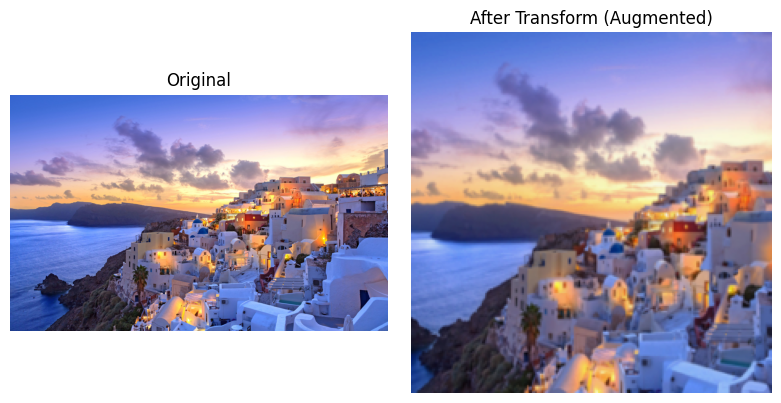

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# pick one sample index from your training dataset
idx = 2000
img_path = train_dataset.image_paths[idx]

# --- Original Image (no transform) ---
original_img = Image.open(img_path).convert("RGB")

# --- Transformed Image (through dataset transform) ---
transformed_img, label = train_dataset[idx]  # this automatically applies train_transform

# Convert the transformed tensor back to displayable format
# (undo normalization if you used it)
import torchvision.transforms as T

# assuming you normalized using mean/std of ImageNet
unnormalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# undo normalization
img_show = unnormalize(transformed_img)
img_show = T.ToPILImage()(img_show)

# --- Plot side by side ---
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(original_img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_show)
plt.title("After Transform (Augmented)")
plt.axis("off")

plt.tight_layout()
plt.show()


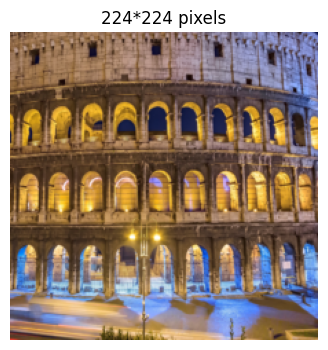

(224, 224)


In [127]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Load an example image
img_path = "dataset/train_Roman Colosseum - Rome_1950.jpg"   # change this to your own path
img = Image.open(img_path).convert("RGB")


# 3️⃣ RandomResizedCrop only
crop_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
])
cropped_img = crop_transform(img)

plt.figure(figsize=(4,4))
plt.imshow(cropped_img)
plt.title("224*224 pixels")
plt.axis("off")
plt.show()

print(cropped_img.size)


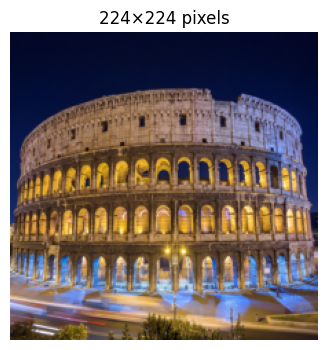

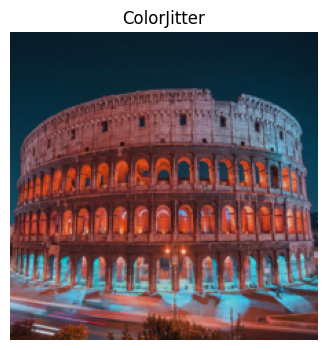

(224, 224)


In [133]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Load your image
img = Image.open("dataset/train_Roman Colosseum - Rome_1950.jpg").convert("RGB")

# 1️⃣ Resize to fixed 224×224
resize_transform = transforms.Resize((224, 224))
img_resized = resize_transform(img)

plt.figure(figsize=(4,4))
plt.imshow(img_resized)
plt.title("224×224 pixels")
plt.axis("off")
plt.show()

# 2️⃣ Apply ColorJitter to the same resized image
color_jitter = transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)
img_jittered = color_jitter(img_resized)

plt.figure(figsize=(4,4))
plt.imshow(img_jittered)
plt.title("ColorJitter")
plt.axis("off")
plt.show()

print(img_jittered.size)


Tensor shape: torch.Size([3, 224, 224])


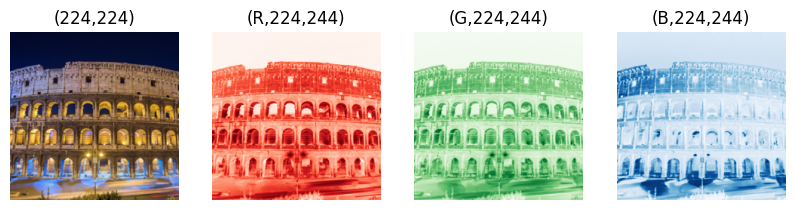

In [131]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Load image
img_path = "dataset/train_Roman Colosseum - Rome_1950.jpg"
img = Image.open(img_path).convert("RGB")

# Transform: crop, flip, to tensor
crop_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
img_tensor = crop_transform(img)  # shape: [3, 224, 224]

print("Tensor shape:", img_tensor.shape)  # [C,H,W]

# Split channels
R = img_tensor[0]
G = img_tensor[1]
B = img_tensor[2]

# Convert each channel to numpy for plotting
R_np = R.numpy()
G_np = G.numpy()
B_np = B.numpy()

# Plot original + R/G/B channels
plt.figure(figsize=(10,3))

plt.subplot(1,4,1)
plt.imshow(img_tensor.permute(1,2,0))  # full RGB
plt.title("(224,224)")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(R_np, cmap='Reds')
plt.title("(R,224,244)")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(G_np, cmap='Greens')
plt.title("(G,224,244)")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(B_np, cmap='Blues')
plt.title("(B,224,244)")
plt.axis("off")

plt.show()


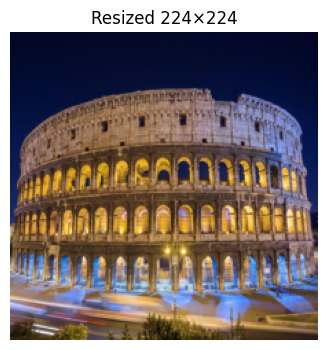

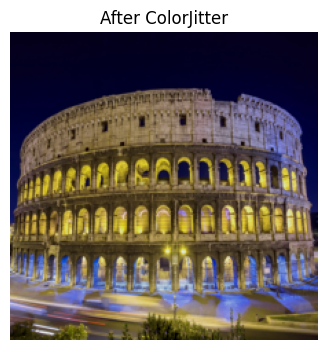

Tensor shape: torch.Size([3, 224, 224])
Tensor min/max: -2.1179039478302 2.1519827842712402


In [134]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Load your image
img = Image.open("dataset/train_Roman Colosseum - Rome_1950.jpg").convert("RGB")

# 1️⃣ Resize to fixed 224×224
resize_transform = transforms.Resize((224, 224))
img_resized = resize_transform(img)

plt.figure(figsize=(4,4))
plt.imshow(img_resized)
plt.title("Resized 224×224")
plt.axis("off")
plt.show()

# 2️⃣ Apply ColorJitter only
color_jitter_transform = transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)
img_jittered = color_jitter_transform(img_resized)

plt.figure(figsize=(4,4))
plt.imshow(img_jittered)
plt.title("After ColorJitter")
plt.axis("off")
plt.show()

# 3️⃣ Apply ToTensor + Normalize
tensor_normalize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

img_tensor = tensor_normalize_transform(img_jittered)
print("Tensor shape:", img_tensor.shape)
print("Tensor min/max:", img_tensor.min().item(), img_tensor.max().item())


In [96]:
from PIL import Image
from torchvision import transforms

img = Image.open("dataset/train_Roman Colosseum - Rome_1950.jpg").convert("RGB")
print("Original size:", img.size)

resize_transform = transforms.Resize(256)
resized_img = resize_transform(img)
print("After Resize(256):", resized_img.size)


Original size: (3797, 2848)
After Resize(256): (341, 256)


In [55]:
# Iterate
for imgs, labels in train_loader:
    print(imgs.shape, labels)

torch.Size([32, 3, 224, 224]) tensor([ 4,  1,  6,  5, 11,  4,  2, 14,  1, 12,  6, 11,  0, 10,  8,  1,  1,  6,
        15,  6,  4,  1, 17, 10, 17,  0, 15, 15,  5,  4,  9, 13])
torch.Size([32, 3, 224, 224]) tensor([ 0,  8,  8,  2,  1, 11,  4,  9,  4,  2, 10, 14, 10, 10, 13, 11,  4,  2,
         1, 17,  4,  0, 12,  7, 16,  0, 12, 12,  3, 14,  9, 15])
torch.Size([32, 3, 224, 224]) tensor([12, 15, 17, 11,  1,  8, 14,  9, 12, 13,  7, 11,  7,  2, 15,  9,  5,  3,
        16, 10,  8,  2,  2,  4, 10,  0, 15,  9, 13, 11,  3, 16])
torch.Size([32, 3, 224, 224]) tensor([ 6,  5,  5,  4,  9,  7,  5, 12, 10,  9,  2, 13, 11,  0, 13, 15, 10, 16,
         4, 11,  0, 11,  6, 17,  0, 16,  0,  8,  6, 14, 16, 12])
torch.Size([32, 3, 224, 224]) tensor([ 9,  9, 10,  6,  9, 12, 12,  5,  1,  7,  0, 11, 16, 11,  4,  0, 13, 15,
         0, 12, 10, 14,  0, 11,  1, 17, 17,  6, 13,  8,  1, 13])
torch.Size([32, 3, 224, 224]) tensor([ 6,  5, 14, 10,  7,  4,  2, 17, 17, 17,  7,  8,  8,  9, 10,  0,  0,  6,
         4, 11,

KeyboardInterrupt: 

In [54]:
train_dataset.image_paths

['data/train\\Antarctica\\1.antarctica-stabbing-1_600.jpg',
 'data/train\\Antarctica\\10.Surprising-Science-Antarctica-Ice-Sheets.jpg',
 'data/train\\Antarctica\\10.jpg',
 'data/train\\Antarctica\\102.jpg',
 'data/train\\Antarctica\\103.jpg',
 'data/train\\Antarctica\\104.jpg',
 'data/train\\Antarctica\\105.jpg',
 'data/train\\Antarctica\\108.jpg',
 'data/train\\Antarctica\\109.jpg',
 'data/train\\Antarctica\\11.AntarcticIceLossFasterOfCourse_600.jpg',
 'data/train\\Antarctica\\11.jpg',
 'data/train\\Antarctica\\111.jpg',
 'data/train\\Antarctica\\112.jpg',
 'data/train\\Antarctica\\113.jpg',
 'data/train\\Antarctica\\114.jpg',
 'data/train\\Antarctica\\115.jpg',
 'data/train\\Antarctica\\116.jpg',
 'data/train\\Antarctica\\117.jpg',
 'data/train\\Antarctica\\118.jpg',
 'data/train\\Antarctica\\12.antarctica-fun-facts.jpg',
 'data/train\\Antarctica\\12.jpg',
 'data/train\\Antarctica\\120.jpg',
 'data/train\\Antarctica\\122.jpg',
 'data/train\\Antarctica\\124.jpg',
 'data/train\\Antarct

In [23]:
import torch
import torch.nn as nn
from torchvision import models
from torchsummary import summary

# Full ResNet-50
resnet = models.resnet50(pretrained=True).to("cuda")
summary(resnet, (3, 224, 224))  # input size: 3-channel, 224x224



c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [25]:
# Features only (remove last 2 layers)
features = torch.nn.Sequential(*list(resnet.children())[:-2]).to("cuda")
summary(features, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import ImageFile
from DELG_Class import DELG
from torchsummary import summary
import torch.nn.functional as F

ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda")
num_epochs = 10
learning_rate = 1e-4
num_classes = 18  # your dataset classes


# DELF Pretrained (Local only)

In [27]:
model = DELG(pretrained=True, use_local=True, use_global=False).to(device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [28]:
torch.save({'model_state_dict': model.state_dict()}, "delf_local_pretrained_only.pth")

# DELG Pretrained (Global only)

In [29]:
model = DELG(pretrained=True, use_local=False, use_global=True).to(device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [30]:
torch.save({'model_state_dict': model.state_dict()}, "delg_global_pretrained_only.pth")

# DELG Pretrained (Global + Local)

In [31]:
model = DELG(pretrained=True, use_global=True, use_local=True).to(device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [32]:
torch.save({'model_state_dict': model.state_dict()}, "delg_both_pretrained.pth")

# DELF (fine-tuned local / no backbone)

In [33]:
model = DELG(pretrained=True, use_global=False, use_local=True).to(device)

# Freeze backbone entirely
for param in model.backbone.parameters():
    param.requires_grad = False

# GeM is not used, so nothing to freeze there

# Enable training for local attention module
for param in model.attention.parameters():
    param.requires_grad = True

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [34]:
# Classifier for local descriptors (aggregated)
classifier = nn.Linear(2048, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    list(model.attention.parameters()) + list(classifier.parameters()),
    lr=learning_rate
)

for epoch in range(num_epochs):
    model.train()
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        local_output = model(imgs)['local']['descriptors']  # [B, H*W, 2048]
        feats = local_output.mean(dim=1)                     # Aggregate to [B, 2048]
        feats = F.normalize(feats, p=2, dim=1)
        
        outputs = classifier(feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loop.set_postfix(loss=running_loss/total, acc=100.*correct/total)

    # ----------------------------
    # Validation
    # ----------------------------
    model.eval()
    classifier.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            local_output = model(imgs)['local']['descriptors']
            feats = local_output.mean(dim=1)
            feats = F.normalize(feats, p=2, dim=1)
            outputs = classifier(feats)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100.*val_correct/val_total
    val_loss_avg = val_loss / val_total
    print(f"Epoch [{epoch+1}/{num_epochs}] | Validation Loss: {val_loss_avg:.4f} | Validation Accuracy: {val_acc:.2f}%\n")

Epoch 1/10: 100%|██████████| 90/90 [02:07<00:00,  1.41s/it, acc=8.84, loss=2.87]


Epoch [1/10] | Validation Loss: 2.8516 | Validation Accuracy: 8.28%



Epoch 2/10: 100%|██████████| 90/90 [01:40<00:00,  1.11s/it, acc=13.3, loss=2.83]


Epoch [2/10] | Validation Loss: 2.8075 | Validation Accuracy: 15.24%



Epoch 3/10: 100%|██████████| 90/90 [01:40<00:00,  1.12s/it, acc=16.1, loss=2.79]


Epoch [3/10] | Validation Loss: 2.7624 | Validation Accuracy: 15.51%



Epoch 4/10: 100%|██████████| 90/90 [01:39<00:00,  1.10s/it, acc=17.1, loss=2.75]


Epoch [4/10] | Validation Loss: 2.7160 | Validation Accuracy: 17.35%



Epoch 5/10: 100%|██████████| 90/90 [01:41<00:00,  1.13s/it, acc=19.2, loss=2.71]


Epoch [5/10] | Validation Loss: 2.6702 | Validation Accuracy: 21.16%



Epoch 6/10: 100%|██████████| 90/90 [01:39<00:00,  1.11s/it, acc=23.8, loss=2.67]


Epoch [6/10] | Validation Loss: 2.6262 | Validation Accuracy: 25.23%



Epoch 7/10: 100%|██████████| 90/90 [01:39<00:00,  1.11s/it, acc=26.7, loss=2.62]


Epoch [7/10] | Validation Loss: 2.5812 | Validation Accuracy: 29.70%



Epoch 8/10: 100%|██████████| 90/90 [01:37<00:00,  1.08s/it, acc=32.5, loss=2.58]


Epoch [8/10] | Validation Loss: 2.5337 | Validation Accuracy: 35.61%



Epoch 9/10: 100%|██████████| 90/90 [01:35<00:00,  1.06s/it, acc=35.9, loss=2.54]


Epoch [9/10] | Validation Loss: 2.4891 | Validation Accuracy: 40.47%



Epoch 10/10: 100%|██████████| 90/90 [01:49<00:00,  1.22s/it, acc=40.7, loss=2.5] 


Epoch [10/10] | Validation Loss: 2.4449 | Validation Accuracy: 44.68%



In [35]:
torch.save({'model_state_dict': model.state_dict()}, "delf_local_finetune_only.pth")

# DELF (finetune Local + backbone)

In [36]:
model = DELG(pretrained=True, use_global=False, use_local=True).to(device)

# Unfreeze backbone so it can train
for param in model.backbone.parameters():
    param.requires_grad = True

# Enable training for local attention module
for param in model.attention.parameters():
    param.requires_grad = True

summary(model, input_size=(3, 224, 224))

c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [37]:
# Classifier for local descriptors (aggregated)
classifier = nn.Linear(2048, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    list(model.backbone.parameters()) + list(model.attention.parameters()) + list(classifier.parameters()),
    lr=learning_rate
)


for epoch in range(num_epochs):
    model.train()
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        local_output = model(imgs)['local']['descriptors']  # [B, H*W, 2048]
        feats = local_output.mean(dim=1)                     # Aggregate to [B, 2048]
        feats = F.normalize(feats, p=2, dim=1)
        
        outputs = classifier(feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loop.set_postfix(loss=running_loss/total, acc=100.*correct/total)

    # ----------------------------
    # Validation
    # ----------------------------
    model.eval()
    classifier.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            local_output = model(imgs)['local']['descriptors']
            feats = local_output.mean(dim=1)
            feats = F.normalize(feats, p=2, dim=1)
            outputs = classifier(feats)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100.*val_correct/val_total
    val_loss_avg = val_loss / val_total
    print(f"Epoch [{epoch+1}/{num_epochs}] | Validation Loss: {val_loss_avg:.4f} | Validation Accuracy: {val_acc:.2f}%\n")

Epoch 1/10: 100%|██████████| 90/90 [01:41<00:00,  1.13s/it, acc=68.6, loss=2.68]


Epoch [1/10] | Validation Loss: 2.4666 | Validation Accuracy: 92.51%



Epoch 2/10: 100%|██████████| 90/90 [01:46<00:00,  1.19s/it, acc=84.1, loss=2.41]


Epoch [2/10] | Validation Loss: 2.2504 | Validation Accuracy: 95.53%



Epoch 3/10: 100%|██████████| 90/90 [01:49<00:00,  1.21s/it, acc=85.7, loss=2.23]


Epoch [3/10] | Validation Loss: 2.0731 | Validation Accuracy: 92.77%



Epoch 4/10: 100%|██████████| 90/90 [01:54<00:00,  1.28s/it, acc=85.6, loss=2.06]


Epoch [4/10] | Validation Loss: 1.8750 | Validation Accuracy: 96.45%



Epoch 5/10: 100%|██████████| 90/90 [01:50<00:00,  1.22s/it, acc=86.1, loss=1.9] 


Epoch [5/10] | Validation Loss: 1.6948 | Validation Accuracy: 96.06%



Epoch 6/10: 100%|██████████| 90/90 [01:48<00:00,  1.21s/it, acc=87, loss=1.74]  


Epoch [6/10] | Validation Loss: 1.5350 | Validation Accuracy: 96.45%



Epoch 7/10: 100%|██████████| 90/90 [02:04<00:00,  1.38s/it, acc=85.3, loss=1.63]


Epoch [7/10] | Validation Loss: 1.4194 | Validation Accuracy: 93.30%



Epoch 8/10: 100%|██████████| 90/90 [02:15<00:00,  1.50s/it, acc=87.5, loss=1.47]


Epoch [8/10] | Validation Loss: 1.2555 | Validation Accuracy: 96.32%



Epoch 9/10: 100%|██████████| 90/90 [02:05<00:00,  1.40s/it, acc=87.9, loss=1.34]


Epoch [9/10] | Validation Loss: 1.1147 | Validation Accuracy: 96.85%



Epoch 10/10: 100%|██████████| 90/90 [01:59<00:00,  1.32s/it, acc=86.7, loss=1.26]


Epoch [10/10] | Validation Loss: 1.0177 | Validation Accuracy: 97.11%



In [38]:
torch.save({'model_state_dict': model.state_dict()}, "delf_local_backbone_finetune.pth")

# DELG (Fine tuned global only / no local)

In [39]:
model = DELG(pretrained=True, use_global=True, use_local=False).to(device)

# Freeze nothing
for param in model.backbone.parameters():
    param.requires_grad = True

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Classification head
classifier = nn.Linear(2048, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    list(model.backbone.parameters()) + list(classifier.parameters()),
    lr=learning_rate
)

# ----------------------------
# Training loop
# ----------------------------
for epoch in range(num_epochs):
    model.train()
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        feats = model(imgs)['global']           # global descriptors only
        outputs = classifier(feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loop.set_postfix(loss=running_loss/total, acc=100.*correct/total)

    # ----------------------------
    # Validation
    # ----------------------------
    model.eval()
    classifier.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            feats = model(imgs)['global']
            outputs = classifier(feats)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100.*val_correct/val_total
    val_loss_avg = val_loss / val_total
    print(f"Epoch [{epoch+1}/{num_epochs}] | Validation Loss: {val_loss_avg:.4f} | Validation Accuracy: {val_acc:.2f}%\n")

Epoch 1/10: 100%|██████████| 90/90 [01:54<00:00,  1.27s/it, acc=60.6, loss=2.72]


Epoch [1/10] | Validation Loss: 2.4967 | Validation Accuracy: 91.72%



Epoch 2/10: 100%|██████████| 90/90 [01:54<00:00,  1.27s/it, acc=83, loss=2.44]  


Epoch [2/10] | Validation Loss: 2.2808 | Validation Accuracy: 94.88%



Epoch 3/10: 100%|██████████| 90/90 [01:53<00:00,  1.26s/it, acc=85.9, loss=2.26]


Epoch [3/10] | Validation Loss: 2.0863 | Validation Accuracy: 95.14%



Epoch 4/10: 100%|██████████| 90/90 [02:02<00:00,  1.36s/it, acc=87.5, loss=2.07]


Epoch [4/10] | Validation Loss: 1.8836 | Validation Accuracy: 97.37%



Epoch 5/10: 100%|██████████| 90/90 [01:56<00:00,  1.29s/it, acc=88.7, loss=1.91]


Epoch [5/10] | Validation Loss: 1.7176 | Validation Accuracy: 96.58%



Epoch 6/10: 100%|██████████| 90/90 [02:00<00:00,  1.33s/it, acc=87.6, loss=1.76]


Epoch [6/10] | Validation Loss: 1.5482 | Validation Accuracy: 97.50%



Epoch 7/10: 100%|██████████| 90/90 [01:58<00:00,  1.32s/it, acc=88, loss=1.61]  


Epoch [7/10] | Validation Loss: 1.3938 | Validation Accuracy: 97.11%



Epoch 8/10: 100%|██████████| 90/90 [02:01<00:00,  1.35s/it, acc=89.6, loss=1.45]


Epoch [8/10] | Validation Loss: 1.2416 | Validation Accuracy: 98.16%



Epoch 9/10: 100%|██████████| 90/90 [01:59<00:00,  1.33s/it, acc=90.1, loss=1.33]


Epoch [9/10] | Validation Loss: 1.1079 | Validation Accuracy: 97.63%



Epoch 10/10: 100%|██████████| 90/90 [02:02<00:00,  1.36s/it, acc=88.9, loss=1.24]


Epoch [10/10] | Validation Loss: 1.0013 | Validation Accuracy: 97.77%



In [41]:
torch.save({'model_state_dict': model.state_dict()}, "delg_global_finetune_no_local.pth")

# DELG (fine tuned global / freeze local)

In [42]:
# Load model and freeze local branch
model = DELG(pretrained=True, use_global=True, use_local=True).to(device)

# Freeze local descriptor (attention) weights
for param in model.attention.parameters():
    param.requires_grad = False

summary(model, input_size=(3, 224, 224))

c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [43]:
# Classification head for fine-tuning global features
classifier = nn.Linear(2048, num_classes).to(device)

# Loss and optimizer (only optimize global + classifier)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    list(model.backbone.parameters()) + list(model.gem.parameters()) + list(classifier.parameters()),
    lr=learning_rate
)

# ----------------------------
# Training loop
# ----------------------------
for epoch in range(num_epochs):
    model.train()
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        feats = model(imgs)['global']           # only global descriptors
        outputs = classifier(feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loop.set_postfix(loss=running_loss/total, acc=100.*correct/total)

    # ----------------------------
    # Validation
    # ----------------------------
    model.eval()
    classifier.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            feats = model(imgs)['global']
            outputs = classifier(feats)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100.*val_correct/val_total
    val_loss_avg = val_loss / val_total
    print(f"Epoch [{epoch+1}/{num_epochs}] | Validation Loss: {val_loss_avg:.4f} | Validation Accuracy: {val_acc:.2f}%\n")


Epoch 1/10: 100%|██████████| 90/90 [01:51<00:00,  1.24s/it, acc=60.2, loss=2.72]


Epoch [1/10] | Validation Loss: 2.5073 | Validation Accuracy: 85.41%



Epoch 2/10: 100%|██████████| 90/90 [02:01<00:00,  1.35s/it, acc=82.1, loss=2.45]


Epoch [2/10] | Validation Loss: 2.2861 | Validation Accuracy: 92.12%



Epoch 3/10: 100%|██████████| 90/90 [02:04<00:00,  1.38s/it, acc=85.3, loss=2.26]


Epoch [3/10] | Validation Loss: 2.0864 | Validation Accuracy: 94.74%



Epoch 4/10: 100%|██████████| 90/90 [02:02<00:00,  1.36s/it, acc=86.3, loss=2.08]


Epoch [4/10] | Validation Loss: 1.9055 | Validation Accuracy: 95.53%



Epoch 5/10: 100%|██████████| 90/90 [02:11<00:00,  1.46s/it, acc=87.2, loss=1.92]


Epoch [5/10] | Validation Loss: 1.7366 | Validation Accuracy: 94.48%



Epoch 6/10: 100%|██████████| 90/90 [02:08<00:00,  1.43s/it, acc=88, loss=1.76]  


Epoch [6/10] | Validation Loss: 1.5674 | Validation Accuracy: 96.06%



Epoch 7/10: 100%|██████████| 90/90 [02:12<00:00,  1.47s/it, acc=87.8, loss=1.62]


Epoch [7/10] | Validation Loss: 1.3994 | Validation Accuracy: 97.11%



Epoch 8/10: 100%|██████████| 90/90 [02:04<00:00,  1.39s/it, acc=88.2, loss=1.47]


Epoch [8/10] | Validation Loss: 1.2495 | Validation Accuracy: 97.63%



Epoch 9/10: 100%|██████████| 90/90 [02:01<00:00,  1.35s/it, acc=89.7, loss=1.33]


Epoch [9/10] | Validation Loss: 1.1189 | Validation Accuracy: 97.50%



Epoch 10/10: 100%|██████████| 90/90 [02:02<00:00,  1.36s/it, acc=89.7, loss=1.23]


Epoch [10/10] | Validation Loss: 1.0113 | Validation Accuracy: 96.58%



In [44]:
torch.save({'model_state_dict': model.state_dict()}, "delg_global_finetune_local_pretrained.pth")

In [5]:
# Load model and freeze local branch
model = DELG(pretrained=True, use_global=True, use_local=True).to(device)

# Freeze local descriptor (attention) weights
for param in model.attention.parameters():
    param.requires_grad = False

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [6]:
classifier = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
).to(device)

# Loss and optimizer (only optimize global + classifier)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    list(model.backbone.parameters()) + list(model.gem.parameters()) + list(classifier.parameters()),
    lr=learning_rate
)

# ----------------------------
# Training loop
# ----------------------------
for epoch in range(num_epochs):
    model.train()
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        feats = model(imgs)['global']           # only global descriptors
        outputs = classifier(feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loop.set_postfix(loss=running_loss/total, acc=100.*correct/total)

    # ----------------------------
    # Validation
    # ----------------------------
    model.eval()
    classifier.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            feats = model(imgs)['global']
            outputs = classifier(feats)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100.*val_correct/val_total
    val_loss_avg = val_loss / val_total
    print(f"Epoch [{epoch+1}/{num_epochs}] | Validation Loss: {val_loss_avg:.4f} | Validation Accuracy: {val_acc:.2f}%\n")

Epoch 1/10: 100%|██████████| 90/90 [02:10<00:00,  1.45s/it, acc=33.3, loss=2.75]


Epoch [1/10] | Validation Loss: 2.4826 | Validation Accuracy: 70.57%



Epoch 2/10: 100%|██████████| 90/90 [01:42<00:00,  1.14s/it, acc=63.7, loss=2.18]


Epoch [2/10] | Validation Loss: 1.7413 | Validation Accuracy: 72.80%



Epoch 3/10: 100%|██████████| 90/90 [01:44<00:00,  1.16s/it, acc=76.4, loss=1.5] 


Epoch [3/10] | Validation Loss: 1.0270 | Validation Accuracy: 85.41%



Epoch 4/10: 100%|██████████| 90/90 [01:44<00:00,  1.16s/it, acc=81.7, loss=1.02]


Epoch [4/10] | Validation Loss: 0.6108 | Validation Accuracy: 91.46%



Epoch 5/10: 100%|██████████| 90/90 [01:47<00:00,  1.19s/it, acc=84.1, loss=0.771]


Epoch [5/10] | Validation Loss: 0.4127 | Validation Accuracy: 93.30%



Epoch 6/10: 100%|██████████| 90/90 [01:48<00:00,  1.21s/it, acc=85.9, loss=0.631]


Epoch [6/10] | Validation Loss: 0.2988 | Validation Accuracy: 96.71%



Epoch 7/10: 100%|██████████| 90/90 [01:47<00:00,  1.19s/it, acc=88.3, loss=0.535]


Epoch [7/10] | Validation Loss: 0.2518 | Validation Accuracy: 96.85%



Epoch 8/10: 100%|██████████| 90/90 [01:48<00:00,  1.20s/it, acc=89.9, loss=0.448]


Epoch [8/10] | Validation Loss: 0.1789 | Validation Accuracy: 98.03%



Epoch 9/10: 100%|██████████| 90/90 [01:52<00:00,  1.25s/it, acc=90.6, loss=0.387]


Epoch [9/10] | Validation Loss: 0.1290 | Validation Accuracy: 98.55%



Epoch 10/10: 100%|██████████| 90/90 [01:46<00:00,  1.19s/it, acc=90.7, loss=0.364]


Epoch [10/10] | Validation Loss: 0.1236 | Validation Accuracy: 97.77%



In [7]:
torch.save({'model_state_dict': model.state_dict()}, "delg_global_finetune_local_pretrained_v2.pth")

# DELG (global fin tune / freeze local but keep keypoint)

In [47]:
model = DELG(pretrained=True, use_global=True, use_local=True).to(device)

# Freeze local descriptor branch (attention)
for param in model.attention.parameters():
    param.requires_grad = False

summary(model, input_size=(3, 224, 224))

c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# ----------------------------
# 2️⃣ Add classification head for global descriptors
# ----------------------------
classifier = nn.Linear(2048, num_classes).to(device)
criterion = nn.CrossEntropyLoss()

# Only optimize global + classifier
optimizer = torch.optim.Adam(
    list(model.backbone.parameters()) + list(model.gem.parameters()) + list(classifier.parameters()),
    lr=learning_rate
)

# ----------------------------
# 3️⃣ Training loop with validation
# ----------------------------
for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        feats = model(imgs)              # forward: compute global + local descriptors
        global_feats = feats['global']   # global for classification
        outputs = classifier(global_feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loop.set_postfix(loss=running_loss/total, acc=100.*correct/total)

    train_acc = 100.*correct/total
    train_loss = running_loss/total

    # ---- Validation ----
    model.eval()
    classifier.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            feats = model(imgs)
            global_feats = feats['global']
            outputs = classifier(global_feats)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100.*val_correct/val_total
    val_loss_avg = val_loss / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"| Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/10 [Train]: 100%|██████████| 90/90 [02:14<00:00,  1.49s/it, acc=60.7, loss=2.72]


Epoch [1/10] | Train Loss: 2.7153, Train Acc: 60.72% | Val Loss: 2.5014, Val Acc: 88.44%


Epoch 2/10 [Train]: 100%|██████████| 90/90 [01:56<00:00,  1.29s/it, acc=83.3, loss=2.44]


Epoch [2/10] | Train Loss: 2.4350, Train Acc: 83.25% | Val Loss: 2.2793, Val Acc: 92.51%


Epoch 3/10 [Train]: 100%|██████████| 90/90 [01:55<00:00,  1.28s/it, acc=85.9, loss=2.25]


Epoch [3/10] | Train Loss: 2.2485, Train Acc: 85.93% | Val Loss: 2.0878, Val Acc: 93.82%


Epoch 4/10 [Train]: 100%|██████████| 90/90 [01:57<00:00,  1.31s/it, acc=85.7, loss=2.09]


Epoch [4/10] | Train Loss: 2.0892, Train Acc: 85.69% | Val Loss: 1.8915, Val Acc: 97.37%


Epoch 5/10 [Train]: 100%|██████████| 90/90 [02:00<00:00,  1.34s/it, acc=87.5, loss=1.91]


Epoch [5/10] | Train Loss: 1.9078, Train Acc: 87.53% | Val Loss: 1.7207, Val Acc: 96.85%


Epoch 6/10 [Train]: 100%|██████████| 90/90 [01:58<00:00,  1.32s/it, acc=87.5, loss=1.75]


Epoch [6/10] | Train Loss: 1.7537, Train Acc: 87.53% | Val Loss: 1.5422, Val Acc: 97.24%


Epoch 7/10 [Train]: 100%|██████████| 90/90 [01:59<00:00,  1.33s/it, acc=88.4, loss=1.61]


Epoch [7/10] | Train Loss: 1.6074, Train Acc: 88.37% | Val Loss: 1.4025, Val Acc: 96.19%


Epoch 8/10 [Train]: 100%|██████████| 90/90 [02:06<00:00,  1.41s/it, acc=88.9, loss=1.47]


Epoch [8/10] | Train Loss: 1.4731, Train Acc: 88.89% | Val Loss: 1.2533, Val Acc: 97.11%


Epoch 9/10 [Train]: 100%|██████████| 90/90 [02:38<00:00,  1.76s/it, acc=89.8, loss=1.33]


Epoch [9/10] | Train Loss: 1.3302, Train Acc: 89.83% | Val Loss: 1.1237, Val Acc: 97.63%


Epoch 10/10 [Train]: 100%|██████████| 90/90 [02:08<00:00,  1.43s/it, acc=89.7, loss=1.23]


Epoch [10/10] | Train Loss: 1.2300, Train Acc: 89.73% | Val Loss: 1.0041, Val Acc: 97.37%


In [49]:
torch.save({'model_state_dict': model.state_dict()}, "delg_global_finetune_local_pretrained_keypoints.pth")

In [ ]:
torch.save({'model_state_dict': model.state_dict()}, "delg_global_finetune_local_pretrained_keypoints.pth")

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from DELG_Class import DELG
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 1e-4

# --------------------
# Model: local only
# --------------------
model = DELG(pretrained=True, use_global=False, use_local=True).to(device)

# --------------------
# Loss: Triplet for local descriptors
# --------------------
criterion_local = nn.TripletMarginLoss(margin=1.0, p=2)

# --------------------
# Optimizer: backbone + attention
# --------------------
optimizer = torch.optim.Adam(
    list(model.backbone.parameters()) +
    list(model.attention.parameters()),
    lr=learning_rate
)

# --------------------
# Training loop
# --------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        feats = model(imgs)
        local_feats = feats['local']['descriptors']  # [B, H*W, 2048]

        B = local_feats.size(0)
        loss_local = 0.0

        # Hard negative mining within batch
        for i in range(B):
            anchor = local_feats[i]  # [H*W, 2048]
            label_anchor = labels[i]

            # positive: another image in batch with same label
            pos_indices = (labels == label_anchor).nonzero(as_tuple=True)[0]
            pos_indices = pos_indices[pos_indices != i]
            if len(pos_indices) == 0:
                continue
            pos = local_feats[pos_indices[0]]

            # negative: any image with different label
            neg_indices = (labels != label_anchor).nonzero(as_tuple=True)[0]
            if len(neg_indices) == 0:
                continue
            neg = local_feats[neg_indices[0]]

            # flatten to mean descriptor for simplicity
            anchor_mean = anchor.mean(dim=0, keepdim=True)
            pos_mean = pos.mean(dim=0, keepdim=True)
            neg_mean = neg.mean(dim=0, keepdim=True)

            loss_local += criterion_local(anchor_mean, pos_mean, neg_mean)

        if B > 0:
            loss_local /= B  # average over batch

        loss_local.backward()
        optimizer.step()

        running_loss += loss_local.item() * imgs.size(0)
        loop.set_postfix(loss=running_loss/(len(loop.dataset)))

    train_loss_avg = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Local Loss: {train_loss_avg:.4f}")

    # --------------------
    # Validation
    # --------------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)
            feats = model(imgs)
            local_feats = feats['local']['descriptors']
            B = local_feats.size(0)
            batch_loss = 0.0

            for i in range(B):
                anchor = local_feats[i]
                label_anchor = labels[i]

                # positive
                pos_indices = (labels == label_anchor).nonzero(as_tuple=True)[0]
                pos_indices = pos_indices[pos_indices != i]
                if len(pos_indices) == 0:
                    continue
                pos = local_feats[pos_indices[0]]

                # negative
                neg_indices = (labels != label_anchor).nonzero(as_tuple=True)[0]
                if len(neg_indices) == 0:
                    continue
                neg = local_feats[neg_indices[0]]

                anchor_mean = anchor.mean(dim=0, keepdim=True)
                pos_mean = pos.mean(dim=0, keepdim=True)
                neg_mean = neg.mean(dim=0, keepdim=True)

                batch_loss += criterion_local(anchor_mean, pos_mean, neg_mean)

            if B > 0:
                batch_loss /= B
            val_loss += batch_loss.item() * B

    val_loss_avg = val_loss / len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Val Local Loss: {val_loss_avg:.4f}")

# --------------------
# Save trained local-only model
# --------------------
torch.save({'model_state_dict': model.state_dict()}, "delg_finetune_local_only.pth")
print("Local-only DELG model saved as delg_finetune_local_only.pth")


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 12.20 GiB is allocated by PyTorch, and 311.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [52]:
# Global descriptor
global_feat = feats['global']  # [1, 2048]

# Local descriptors & attention map
local_desc = feats['local']['descriptors']  # [1, H*W, 2048]
att_map = feats['local']['attention']    

print(global_feat.shape, local_desc.shape, att_map.shape)

torch.Size([25, 2048]) torch.Size([25, 49, 2048]) torch.Size([25, 1, 7, 7])


In [ ]:
torch.save({'model_state_dict': model.state_dict()}, "delg_global_local_finetune.pth")